### Inverse dynamics of `Panda`

In [1]:
import os,glfw
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco_viewer
np.set_printoptions(precision=2,suppress=True,linewidth=100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.2]


### Parse `Panda`

In [2]:
xml_path='../model/panda/franka_panda.xml'
full_xml_path = os.path.abspath(os.path.join(os.getcwd(),xml_path))
model = mujoco.MjModel.from_xml_path(full_xml_path)
data = mujoco.MjData(model)
print ("[Panda] parsed.")

[Panda] parsed.


In [3]:
n_body          = model.nbody # number of bodies
body_names      = [mujoco.mj_id2name(model,mujoco.mjtObj.mjOBJ_BODY,x) for x in range(n_body)]
n_joint         = model.njnt     # number of joints
joint_names     = [mujoco.mj_id2name(model,mujoco.mjtJoint.mjJNT_HINGE,x) for x in range(n_joint)]
joint_types     = model.jnt_type # joint types
joint_ranges    = model.jnt_range # joint ranges
rev_joint_idxs  = np.where(joint_types==mujoco.mjtJoint.mjJNT_HINGE)[0].astype(np.int32)
rev_joint_names = [joint_names[x] for x in rev_joint_idxs]
n_rev_joint     = len(rev_joint_idxs)
rev_joint_min   = joint_ranges[rev_joint_idxs,0]
rev_joint_max   = joint_ranges[rev_joint_idxs,1]
rev_joint_range = rev_joint_max - rev_joint_min
pri_joint_idxs  = np.where(joint_types==mujoco.mjtJoint.mjJNT_SLIDE)[0].astype(np.int32)
pri_joint_names = [joint_names[x] for x in pri_joint_idxs]
n_pri_joint     = len(pri_joint_idxs)
# Print
print ("n_body:[%d]"%(n_body))
print ("body_names:%s"%(body_names))
print ("n_joint:[%d]"%(n_joint))
print ("joint_names:%s"%(joint_names))
print ("joint_types:%s"%(joint_types))
print ("joint_ranges:\n%s"%(joint_ranges))
print ("n_rev_joint:[%d]"%(n_rev_joint))
print ("rev_joint_idxs:%s"%(rev_joint_idxs))
print ("rev_joint_names:%s"%(rev_joint_names))
print ("rev_joint_min:%s"%(rev_joint_min))
print ("rev_joint_max:%s"%(rev_joint_max))
print ("rev_joint_range:%s"%(rev_joint_range))
print ("n_pri_joint:[%d]"%(n_pri_joint))
print ("pri_joint_idxs:%s"%(pri_joint_idxs))
print ("pri_joint_names:%s"%(pri_joint_names))

n_body:[18]
body_names:['world', 'panda_base', 'panda_pedestal', 'panda_link_0', 'panda_link_1', 'panda_link_2', 'panda_link_3', 'panda_link_4', 'panda_link_5', 'panda_link_6', 'panda_link_7', 'right_hand', 'panda_right_gripper', 'panda_eef', 'panda_leftfinger', 'panda_finger_joint1_tip', 'panda_rightfinger', 'panda_finger_joint2_tip']
n_joint:[9]
joint_names:['panda_joint1', 'panda_joint2', 'panda_joint3', 'panda_joint4', 'panda_joint5', 'panda_joint6', 'panda_joint7', 'panda_finger_joint1', 'panda_finger_joint2']
joint_types:[3 3 3 3 3 3 3 2 2]
joint_ranges:
[[-2.9   2.9 ]
 [-1.76  1.76]
 [-2.9   2.9 ]
 [-3.07 -0.07]
 [-2.9   2.9 ]
 [-0.02  3.75]
 [-2.9   2.9 ]
 [ 0.    0.04]
 [-0.04  0.  ]]
n_rev_joint:[7]
rev_joint_idxs:[0 1 2 3 4 5 6]
rev_joint_names:['panda_joint1', 'panda_joint2', 'panda_joint3', 'panda_joint4', 'panda_joint5', 'panda_joint6', 'panda_joint7']
rev_joint_min:[-2.9  -1.76 -2.9  -3.07 -2.9  -0.02 -2.9 ]
rev_joint_max:[ 2.9   1.76  2.9  -0.07  2.9   3.75  2.9 ]
rev_j

### Free-fall motion

In [4]:
# Viewer
viewer = mujoco_viewer.MujocoViewer(model,data,mode='window',
    title='Panda in MuJoCo',width=1200,height=800,hide_menus=True)
viewer.cam.azimuth   = 80
viewer.cam.distance  = 4.0
viewer.cam.elevation = -30
viewer.cam.lookat = np.array([0,0,1.2])
# simulate and render
mujoco.mj_resetData(model, data)
data.qpos[3] = -90*np.pi/180
data.qpos[5] = 90*np.pi/180
mujoco.mj_forward(model, data)
# Buffers
tick = 0
max_time = 5 # (second)
times,qrevs = [],[]
while data.time < max_time:
    tick = tick + 1
    if viewer.is_alive:
        # Update
        data.ctrl[rev_joint_idxs] = np.zeros(n_rev_joint)
        mujoco.mj_step(model,data,nstep=1)
        if (tick % 10) == 0:
            viewer.render()
    else: break # terminate if viewer is dead
    # Append
    times.append(data.time)
    qrevs.append(data.qpos[rev_joint_idxs])
# close viewer
viewer.close() # do we need this? yes
print ("tick:[%d] [%.2f]sec. Done."%(tick,data.time))

tick:[2501] [5.00]sec. Done.


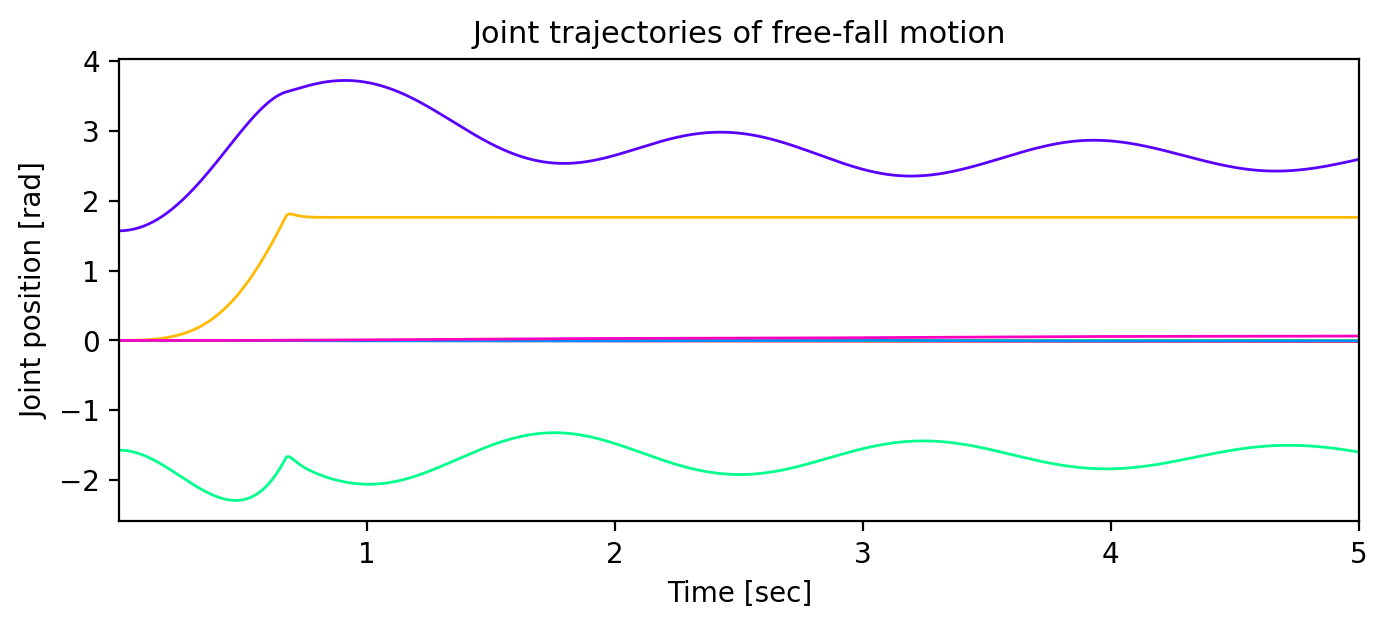

In [5]:
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_rev_joint)]
plt.figure(figsize=(8,3))
for j_idx in range(n_rev_joint):
    plt.plot(np.array(times),np.array(qrevs)[:,j_idx],ls='-',color=cs[j_idx],lw=1)
plt.title('Joint trajectories of free-fall motion',fontsize=11)
plt.xlim(times[0],times[-1])
plt.xlabel('Time [sec]',fontsize=10)
plt.ylabel('Joint position [rad]',fontsize=10)
plt.show()

### Gravity compensation

In [6]:
# Viewer
viewer = mujoco_viewer.MujocoViewer(model,data,mode='window',
    title='Panda in MuJoCo',width=1200,height=800,hide_menus=True)
viewer.cam.azimuth   = 80
viewer.cam.distance  = 4.0
viewer.cam.elevation = -30
viewer.cam.lookat = np.array([0,0,1.2])
# simulate and render
mujoco.mj_resetData(model, data)
data.qpos[3] = -90*np.pi/180
data.qpos[5] = 90*np.pi/180
mujoco.mj_forward(model, data)
# Buffers
tick = 0
max_time = 5 # (second)
times,qrevs = [],[]
while data.time < max_time:
    tick = tick + 1
    if viewer.is_alive:
        # Backup data
        qpos_bu = data.qpos[rev_joint_idxs]
        qvel_bu = data.qvel[rev_joint_idxs]
        qacc_bu = data.qacc[rev_joint_idxs]
        # Inverse dynamics
        data.qvel[rev_joint_idxs] = np.zeros(n_rev_joint)
        data.qacc[rev_joint_idxs] = np.zeros(n_rev_joint)
        mujoco.mj_inverse(model,data)
        ctrl = data.qfrc_inverse*1.0 # get the force from ID
        # Restore
        data.qpos[rev_joint_idxs] = qpos_bu
        data.qvel[rev_joint_idxs] = qvel_bu
        data.qacc[rev_joint_idxs] = qacc_bu
        # Update
        data.ctrl[rev_joint_idxs] = ctrl[rev_joint_idxs]
        mujoco.mj_step(model,data,nstep=1)
        if (tick % 10) == 0:
            viewer.render()
    else: break # terminate if viewer is dead
    # Append
    times.append(data.time)
    qrevs.append(data.qpos[rev_joint_idxs])
# close viewer
viewer.close() # do we need this? yes
print ("tick:[%d] [%.2f]sec. Done."%(tick,data.time))

tick:[2501] [5.00]sec. Done.


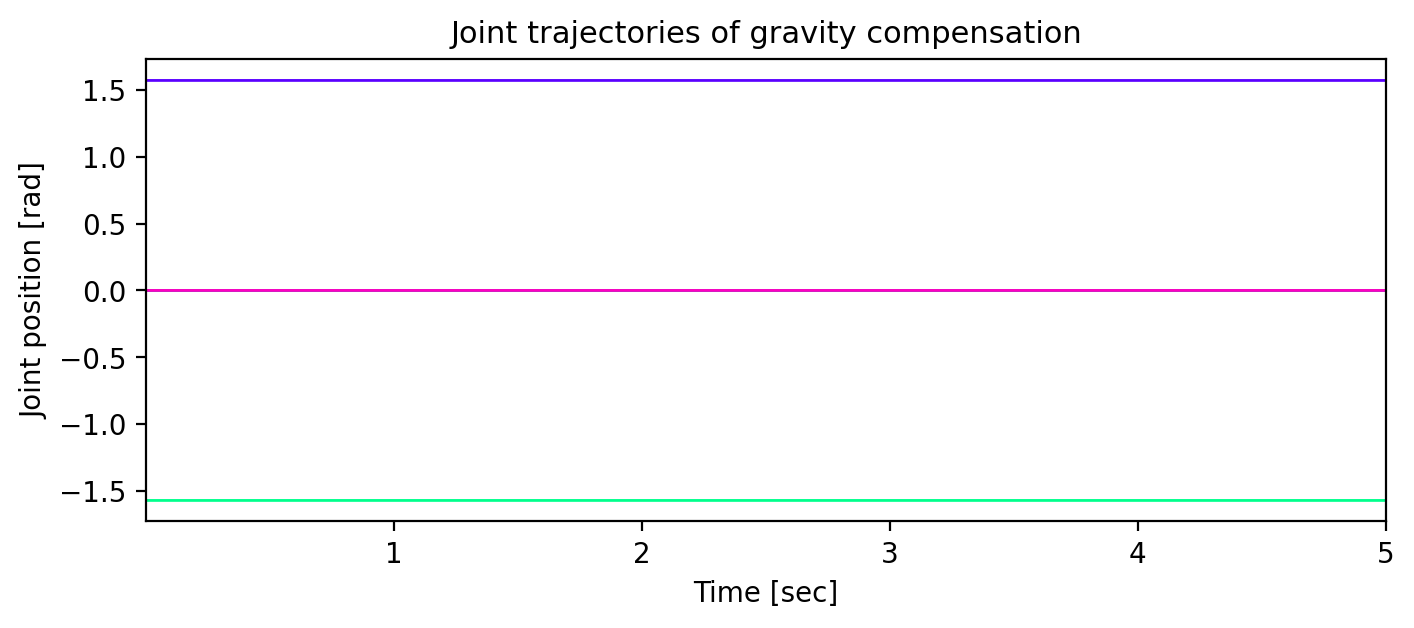

In [7]:
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_rev_joint)]
plt.figure(figsize=(8,3))
for j_idx in range(n_rev_joint):
    plt.plot(np.array(times),np.array(qrevs)[:,j_idx],ls='-',color=cs[j_idx],lw=1)
plt.title('Joint trajectories of gravity compensation',fontsize=11)
plt.xlim(times[0],times[-1])
plt.xlabel('Time [sec]',fontsize=10)
plt.ylabel('Joint position [rad]',fontsize=10)
plt.show()

### Spring-like behavior

In [8]:
# Viewer
viewer = mujoco_viewer.MujocoViewer(model,data,mode='window',
    title='Panda in MuJoCo',width=1200,height=800,hide_menus=True)
viewer.cam.azimuth   = 80
viewer.cam.distance  = 4.0
viewer.cam.elevation = -30
viewer.cam.lookat = np.array([0,0,1.2])
# Desired joint position
q_des = np.array([0,0,0,-90,0,90,0])*np.pi/180.0
# q_des = rev_joint_min + rev_joint_range*np.random.rand(n_rev_joint)
# simulate and render
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)
# Buffers
tick = 0
max_time = 5 # (second)
times,qrevs = [],[]
while data.time < max_time:
    tick = tick + 1
    if viewer.is_alive:
        # Backup data
        qpos_bu = data.qpos[rev_joint_idxs]
        qvel_bu = data.qvel[rev_joint_idxs]
        qacc_bu = data.qacc[rev_joint_idxs]
        # Inverse dynamics
        data.qvel[rev_joint_idxs] = np.zeros(n_rev_joint)
        data.qacc[rev_joint_idxs] = 20.0*(q_des-data.qpos[rev_joint_idxs])
        mujoco.mj_inverse(model,data)
        ctrl = data.qfrc_inverse*1.0 # get the force from ID
        # Restore
        data.qpos[rev_joint_idxs] = qpos_bu
        data.qvel[rev_joint_idxs] = qvel_bu
        data.qacc[rev_joint_idxs] = qacc_bu
        # Update
        data.ctrl[rev_joint_idxs] = ctrl[rev_joint_idxs]
        mujoco.mj_step(model,data,nstep=1)
        if (tick % 10) == 0:
            viewer.render()
    else: break # terminate if viewer is dead
    # Append
    times.append(data.time)
    qrevs.append(data.qpos[rev_joint_idxs])
# close viewer
viewer.close() # do we need this? yes
print ("tick:[%d] [%.2f]sec. Done."%(tick,data.time))

tick:[2501] [5.00]sec. Done.


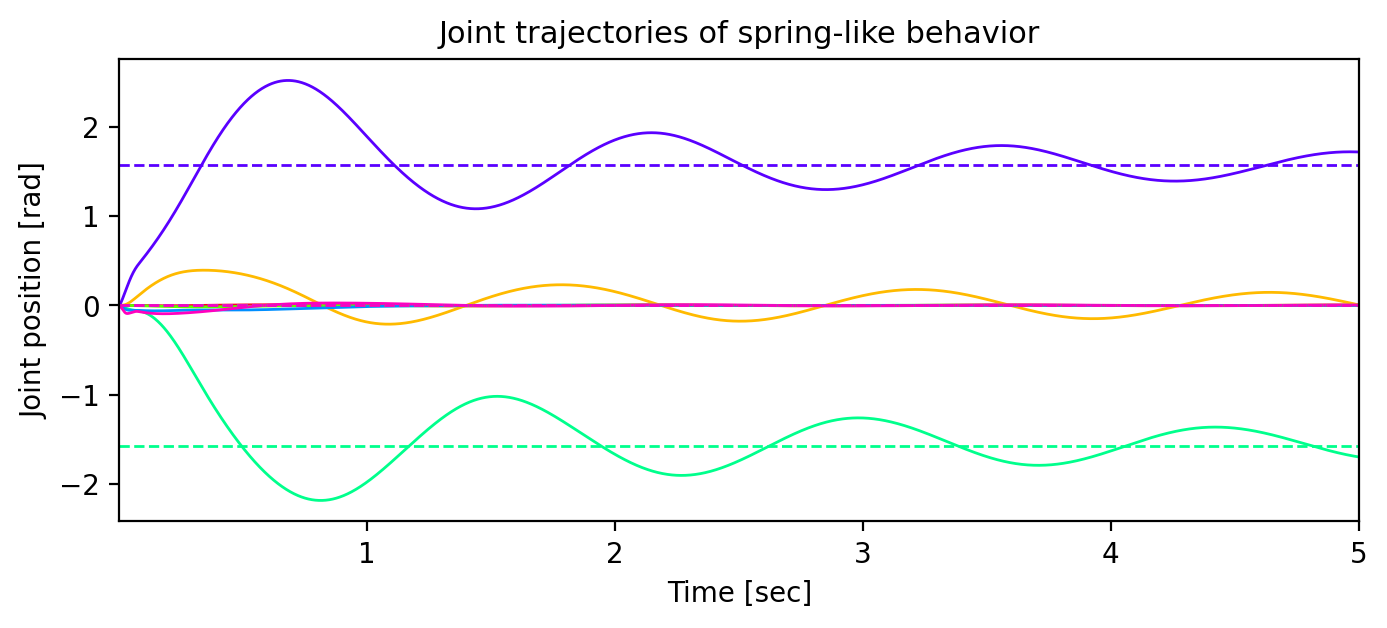

In [9]:
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_rev_joint)]
plt.figure(figsize=(8,3))
for j_idx in range(n_rev_joint):
    plt.plot(np.array(times),np.array(qrevs)[:,j_idx],ls='-',color=cs[j_idx],lw=1)
for j_idx in range(n_rev_joint):
    plt.plot(np.array([times[0],times[-1]]),np.array([q_des[j_idx],q_des[j_idx]]),
             ls='--',color=cs[j_idx],lw=1)
plt.title('Joint trajectories of spring-like behavior',fontsize=11)
plt.xlim(times[0],times[-1])
plt.xlabel('Time [sec]',fontsize=10)
plt.ylabel('Joint position [rad]',fontsize=10)
plt.show()